<a href="https://colab.research.google.com/github/davidemandrini/huggingface-tests/blob/main/transformers_doc/en/pytorch/audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.5 MB/s eta 0:00:00


# Audio classification

In [ ]:
#@title
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/KWwzcmG98Ds?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

Audio classification - just like with text - assigns a class label output from the input data. The only difference is instead of text inputs, you have raw audio waveforms. Some practical applications of audio classification include identifying speaker intent, language classification, and even animal species by their sounds.

This guide will show you how to:

1. Finetune [Wav2Vec2](https://huggingface.co/facebook/wav2vec2-base) on the [MInDS-14](https://huggingface.co/datasets/PolyAI/minds14) dataset to classify speaker intent.
2. Use your finetuned model for inference.

<Tip>
The task illustrated in this tutorial is supported by the following model architectures:

<!--This tip is automatically generated by `make fix-copies`, do not fill manually!-->

[Audio Spectrogram Transformer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/audio-spectrogram-transformer), [Data2VecAudio](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/data2vec-audio), [Hubert](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/hubert), [SEW](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/sew), [SEW-D](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/sew-d), [UniSpeech](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/unispeech), [UniSpeechSat](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/unispeech-sat), [Wav2Vec2](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/wav2vec2), [Wav2Vec2-Conformer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/wav2vec2-conformer), [WavLM](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/wavlm), [Whisper](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/whisper)

<!--End of the generated tip-->

</Tip>

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install transformers datasets evaluate
```

We encourage you to login to your Hugging Face account so you can upload and share your model with the community. When prompted, enter your token to login:

In [65]:
from huggingface_hub import notebook_login

notebook_login()

## Load MInDS-14 dataset

Start by loading the MInDS-14 dataset from the 🤗 Datasets library:

In [46]:
from datasets import load_dataset, Audio

minds = load_dataset("PolyAI/minds14", name="en-US", split="train")

Split the dataset's `train` split into a smaller train and test set with the [train_test_split](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split) method. This'll give you a chance to experiment and make sure everything works before spending more time on the full dataset.

In [47]:
minds = minds.train_test_split(test_size=0.2)

Then take a look at the dataset:

In [48]:
minds

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 450
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 113
    })
})

While the dataset contains a lot of useful information, like `lang_id` and `english_transcription`, you'll focus on the `audio` and `intent_class` in this guide. Remove the other columns with the [remove_columns](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.remove_columns) method:

In [49]:
minds = minds.remove_columns(["path", "transcription", "english_transcription", "lang_id"])

Take a look at an example now:

In [50]:
minds["train"][0]

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/f9018fd3747971e77d59e6c5da3fdf9d5bb914c495e16c23e1fe47c921d76a7a/en-US~DIRECT_DEBIT/602ba1b605f96973d6794404.wav',
  'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00195312,
         -0.00341797, -0.00402832]),
  'sampling_rate': 8000},
 'intent_class': 8}

There are two fields:

- `audio`: a 1-dimensional `array` of the speech signal that must be called to load and resample the audio file.
- `intent_class`: represents the class id of the speaker's intent.

To make it easier for the model to get the label name from the label id, create a dictionary that maps the label name to an integer and vice versa:

In [8]:
labels = minds["train"].features["intent_class"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [10]:
id2label

{'0': 'abroad',
 '1': 'address',
 '2': 'app_error',
 '3': 'atm_limit',
 '4': 'balance',
 '5': 'business_loan',
 '6': 'card_issues',
 '7': 'cash_deposit',
 '8': 'direct_debit',
 '9': 'freeze',
 '10': 'high_value_payment',
 '11': 'joint_account',
 '12': 'latest_transactions',
 '13': 'pay_bill'}

Now you can convert the label id to a label name:

In [9]:
id2label[str(2)]

'app_error'

## Preprocess

The next step is to load a Wav2Vec2 feature extractor to process the audio signal:

In [11]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [58]:
help(feature_extractor)

Help on Wav2Vec2FeatureExtractor in module transformers.models.wav2vec2.feature_extraction_wav2vec2 object:

class Wav2Vec2FeatureExtractor(transformers.feature_extraction_sequence_utils.SequenceFeatureExtractor)
 |  Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, return_attention_mask=False, do_normalize=True, **kwargs)
 |  
 |  Constructs a Wav2Vec2 feature extractor.
 |  
 |  This feature extractor inherits from [`~feature_extraction_sequence_utils.SequenceFeatureExtractor`] which contains
 |  most of the main methods. Users should refer to this superclass for more information regarding those methods.
 |  
 |  Args:
 |      feature_size (`int`, *optional*, defaults to 1):
 |          The feature dimension of the extracted features.
 |      sampling_rate (`int`, *optional*, defaults to 16000):
 |          The sampling rate at which the audio files should be digitalized expressed in hertz (Hz).
 |      padding_value (`float`, *optional*, defaults to 0.

The MInDS-14 dataset has a sampling rate of 8000khz (you can find this information in it's [dataset card](https://huggingface.co/datasets/PolyAI/minds14)), which means you'll need to resample the dataset to 16000kHz to use the pretrained Wav2Vec2 model:

In [12]:
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
minds["train"][0]

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/f9018fd3747971e77d59e6c5da3fdf9d5bb914c495e16c23e1fe47c921d76a7a/en-US~FREEZE/602baf3cbb1e6d0fbce922b3.wav',
  'array': array([-1.04710853e-05, -6.59661600e-06,  1.07920905e-05, ...,
          1.70174520e-04,  3.45064291e-05, -6.10546049e-05]),
  'sampling_rate': 16000},
 'intent_class': 9}

Now create a preprocessing function that:

1. Calls the `audio` column to load, and if necessary, resample the audio file.
2. Checks if the sampling rate of the audio file matches the sampling rate of the audio data a model was pretrained with. You can find this information in the Wav2Vec2 [model card](https://huggingface.co/facebook/wav2vec2-base).
3. Set a maximum input length to batch longer inputs without truncating them.

In [14]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True
    )
    return inputs

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) function. You can speed up `map` by setting `batched=True` to process multiple elements of the dataset at once. Remove the columns you don't need, and rename `intent_class` to `label` because that's the name the model expects:

In [15]:
encoded_minds = minds.map(preprocess_function, remove_columns="audio", batched=True)
encoded_minds = encoded_minds.rename_column("intent_class", "label")

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/113 [00:00<?, ? examples/s]

In [25]:
one_training_sample = encoded_minds["train"].take(1).to_dict()

In [27]:
print(len(one_training_sample['input_values'][0]))

16000


In [57]:
# It seems that we have samples of 1 second? Let's check

minds["train"][0]["audio"]["array"].shape[0] / minds["train"][0]["audio"]["sampling_rate"]

11.349375

In [80]:
# We decided to only keep 1s of audio when in the "preprocess_function" we call "feature_extractor" with "max_length=16000" (with the sample rate being the same value)

# Is the audio only truncated or what? Let's check

# Original samples are at 8khz, training samples have been converted at 16khz, we need to consider that

In [75]:
minds["train"][0]["audio"]["array"][:20]

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.00024414,
       -0.00024414,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00024414,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00024414,  0.        ])

In [79]:
one_training_sample['input_values'][0][:10]

[-0.00213496177457273,
 -0.0012041054433211684,
 0.0029735988937318325,
 0.002521916525438428,
 -0.0022522436920553446,
 -0.0024198039900511503,
 0.0030127244535833597,
 0.003986692521721125,
 -0.002205288503319025,
 -0.004261879250407219]

In [82]:
from matplotlib.pyplot import plot

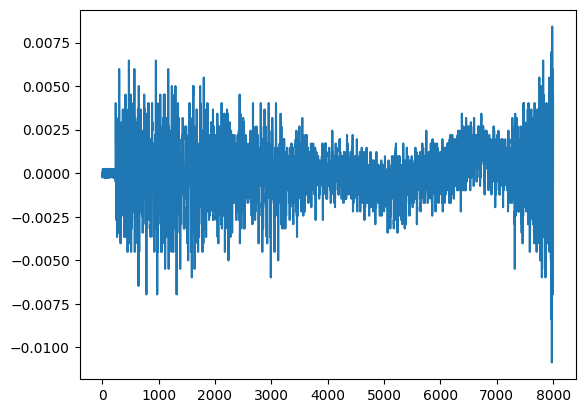

In [92]:
# 1 second is 8000 samples here
plot(minds["train"][0]["audio"]["array"][:8000])

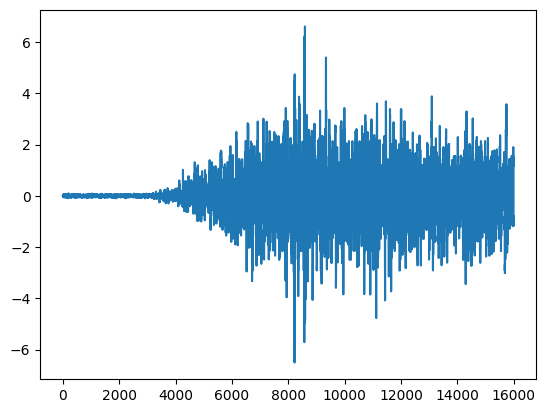

In [93]:
# 1 second here is 16000 samples
plot(one_training_sample['input_values'][0][:16000])

In [95]:
# Let's listen to the sample
from IPython.display import Audio

Audio(data=minds["train"][0]["audio"]["array"], rate=8000)

In [96]:
Audio(data=one_training_sample['input_values'][0], rate=16000)

In [103]:
# Let's apply the feature_extractor to the raw_audio with no lenght duration
Audio(
    data=feature_extractor(minds["train"][0]["audio"]["array"], sampling_rate=feature_extractor.sampling_rate)["input_values"][0],
    rate=16000
)

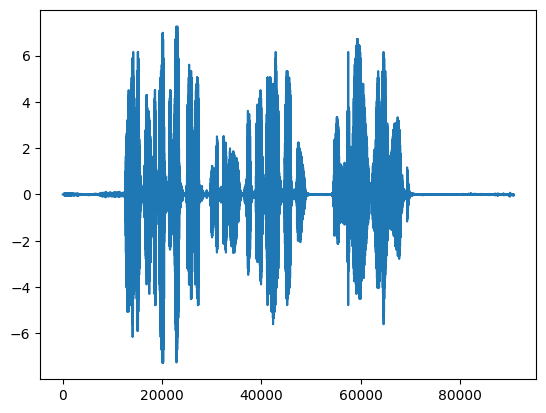

In [104]:
plot(feature_extractor(minds["train"][0]["audio"]["array"], sampling_rate=feature_extractor.sampling_rate)["input_values"][0])

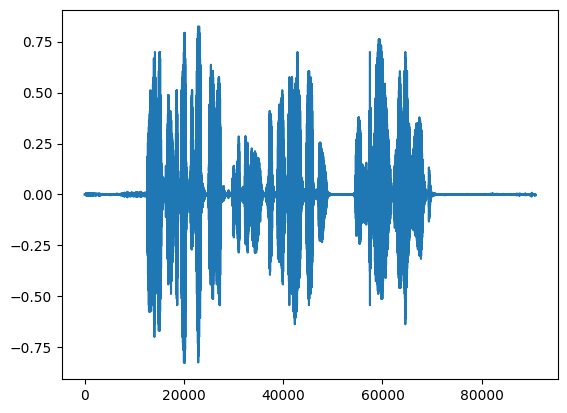

In [105]:
plot(minds["train"][0]["audio"]["array"])

## Evaluate

Including a metric during training is often helpful for evaluating your model's performance. You can quickly load a evaluation method with the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load the [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) metric (see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

In [60]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00


In [61]:
import evaluate

accuracy = evaluate.load("accuracy")

Then create a function that passes your predictions and labels to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) to calculate the accuracy:

In [62]:
import numpy as np


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

Your `compute_metrics` function is ready to go now, and you'll return to it when you setup your training.

## Train

<Tip>

If you aren't familiar with finetuning a model with the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer), take a look at the basic tutorial [here](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer)!

</Tip>

You're ready to start training your model now! Load Wav2Vec2 with [AutoModelForAudioClassification](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForAudioClassification) along with the number of expected labels, and the label mappings:

In [63]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_labels, label2id=label2id, id2label=id2label
)

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
# Test the model output before fine tuning
import torch

In [107]:
sampling_rate = 16000
inputs = feature_extractor(minds["train"][0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")

In [109]:
inputs

{'input_values': tensor([[-0.0001, -0.0001, -0.0001,  ..., -0.0173, -0.0302, -0.0356]])}

In [111]:
inputs["input_values"].shape

torch.Size([1, 90795])

In [125]:
with torch.no_grad():
  res = model(**inputs)
res

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


SequenceClassifierOutput(loss=None, logits=tensor([[-0.0042, -0.0563,  0.0228, -0.0121, -0.0087,  0.0183,  0.0373, -0.0064,
          0.0012, -0.0068, -0.0225,  0.0673, -0.0204, -0.0147]]), hidden_states=None, attentions=None)

In [115]:
res.logits.shape

torch.Size([1, 14])

In [121]:
size_of_first_example_from_before = 11.349375

In [123]:
size_of_first_example_from_before / 14

0.8106696428571428

At this point, only three steps remain:

1. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). The only required parameter is `output_dir` which specifies where to save your model. You'll push this model to the Hub by setting `push_to_hub=True` (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) will evaluate the accuracy and save the training checkpoint.
2. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

In [66]:
training_args = TrainingArguments(
    output_dir="my_awesome_mind_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_minds["train"],
    eval_dataset=encoded_minds["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-66-9cda9791ae95>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: davide-mandrini (davide-mandrini-it) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,2.636156,0.070796


KeyboardInterrupt: 

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [ ]:
trainer.push_to_hub()

<Tip>

For a more in-depth example of how to finetune a model for audio classification, take a look at the corresponding [PyTorch notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/audio_classification.ipynb).

</Tip>

## Inference

Great, now that you've finetuned a model, you can use it for inference!

Load an audio file you'd like to run inference on. Remember to resample the sampling rate of the audio file to match the sampling rate of the model if you need to!

In [ ]:
from datasets import load_dataset, Audio

dataset = load_dataset("PolyAI/minds14", name="en-US", split="train")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
sampling_rate = dataset.features["audio"].sampling_rate
audio_file = dataset[0]["audio"]["path"]

The simplest way to try out your finetuned model for inference is to use it in a [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline). Instantiate a `pipeline` for audio classification with your model, and pass your audio file to it:

In [ ]:
from transformers import pipeline

classifier = pipeline("audio-classification", model="stevhliu/my_awesome_minds_model")
classifier(audio_file)

[
    {'score': 0.09766869246959686, 'label': 'cash_deposit'},
    {'score': 0.07998877018690109, 'label': 'app_error'},
    {'score': 0.0781070664525032, 'label': 'joint_account'},
    {'score': 0.07667109370231628, 'label': 'pay_bill'},
    {'score': 0.0755252093076706, 'label': 'balance'}
]

You can also manually replicate the results of the `pipeline` if you'd like:

Load a feature extractor to preprocess the audio file and return the `input` as PyTorch tensors:

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("stevhliu/my_awesome_minds_model")
inputs = feature_extractor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")

Pass your inputs to the model and return the logits:

In [ ]:
from transformers import AutoModelForAudioClassification

model = AutoModelForAudioClassification.from_pretrained("stevhliu/my_awesome_minds_model")
with torch.no_grad():
    logits = model(**inputs).logits

Get the class with the highest probability, and use the model's `id2label` mapping to convert it to a label:

In [ ]:
import torch

predicted_class_ids = torch.argmax(logits).item()
predicted_label = model.config.id2label[predicted_class_ids]
predicted_label

'cash_deposit'